In [1]:
# %load /Users/hwayment/ipynb_defaults.py
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
mpl.rcParams['figure.dpi']= 300

from matplotlib.colors import LogNorm

from glob import glob
import os, sys, pickle, requests

from arnie.revi.revi import REVI
from copy import copy

Populating the interactive namespace from numpy and matplotlib


In [3]:
sequence = "GGGGAAAACCCC"

estimator = REVI(sequence, n_samples=10, n_iters=5)
estimator.reweight()

RNIE reweighting:


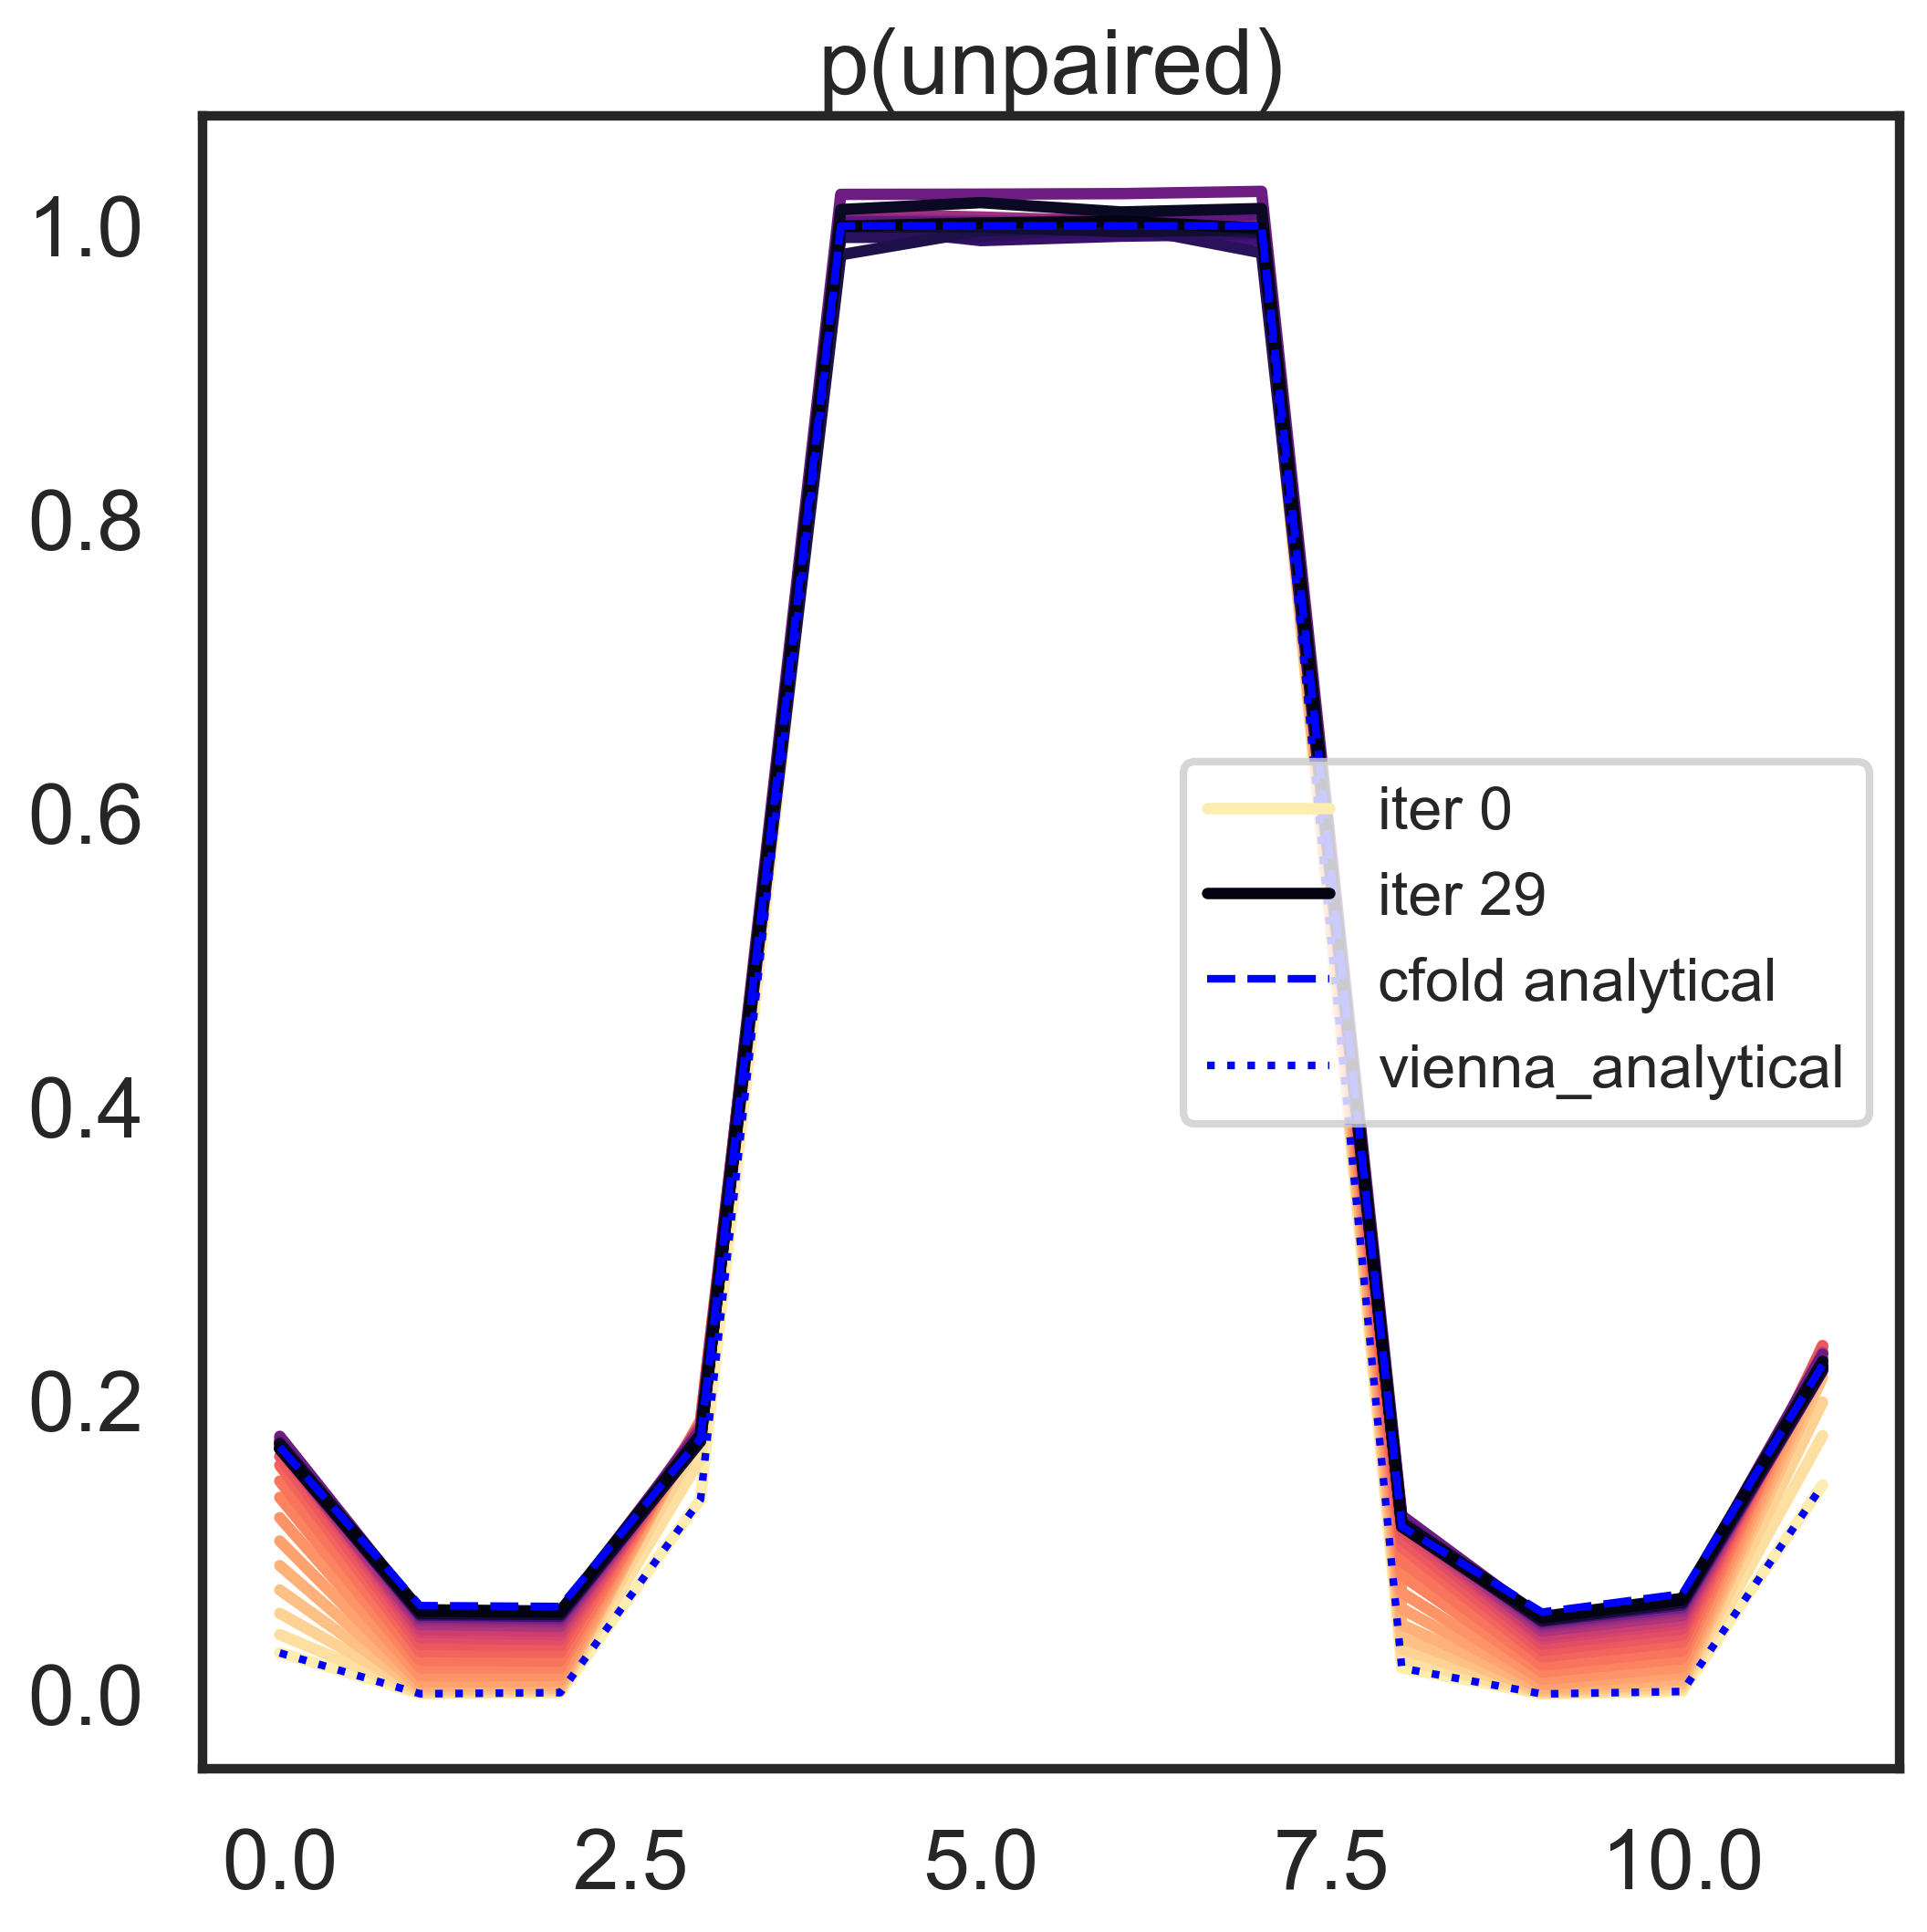

In [283]:
figure(figsize=(8,8))
colors=sns.color_palette('magma_r',estimator.n_iters)
title('p(unpaired)')
for i,vec in enumerate(estimator.posteriors):
    if i==0 or i==estimator.n_iters-1:
        plot(vec,c=colors[i],label="iter %d" % i)
    else:
        plot(vec,c=colors[i])

plot(1-np.sum(bpps(sequence,package='contrafold'),axis=0),linewidth=2,label='cfold analytical',color='b',linestyle='--')
plot(1-np.sum(bpps(sequence,package='vienna_2'),axis=0),linewidth=2,label = 'vienna_analytical',color='b',linestyle=':')
#semilogy()
legend(fontsize=16)
#savefig('ex1_posterior.pdf',bbox_inches='tight')

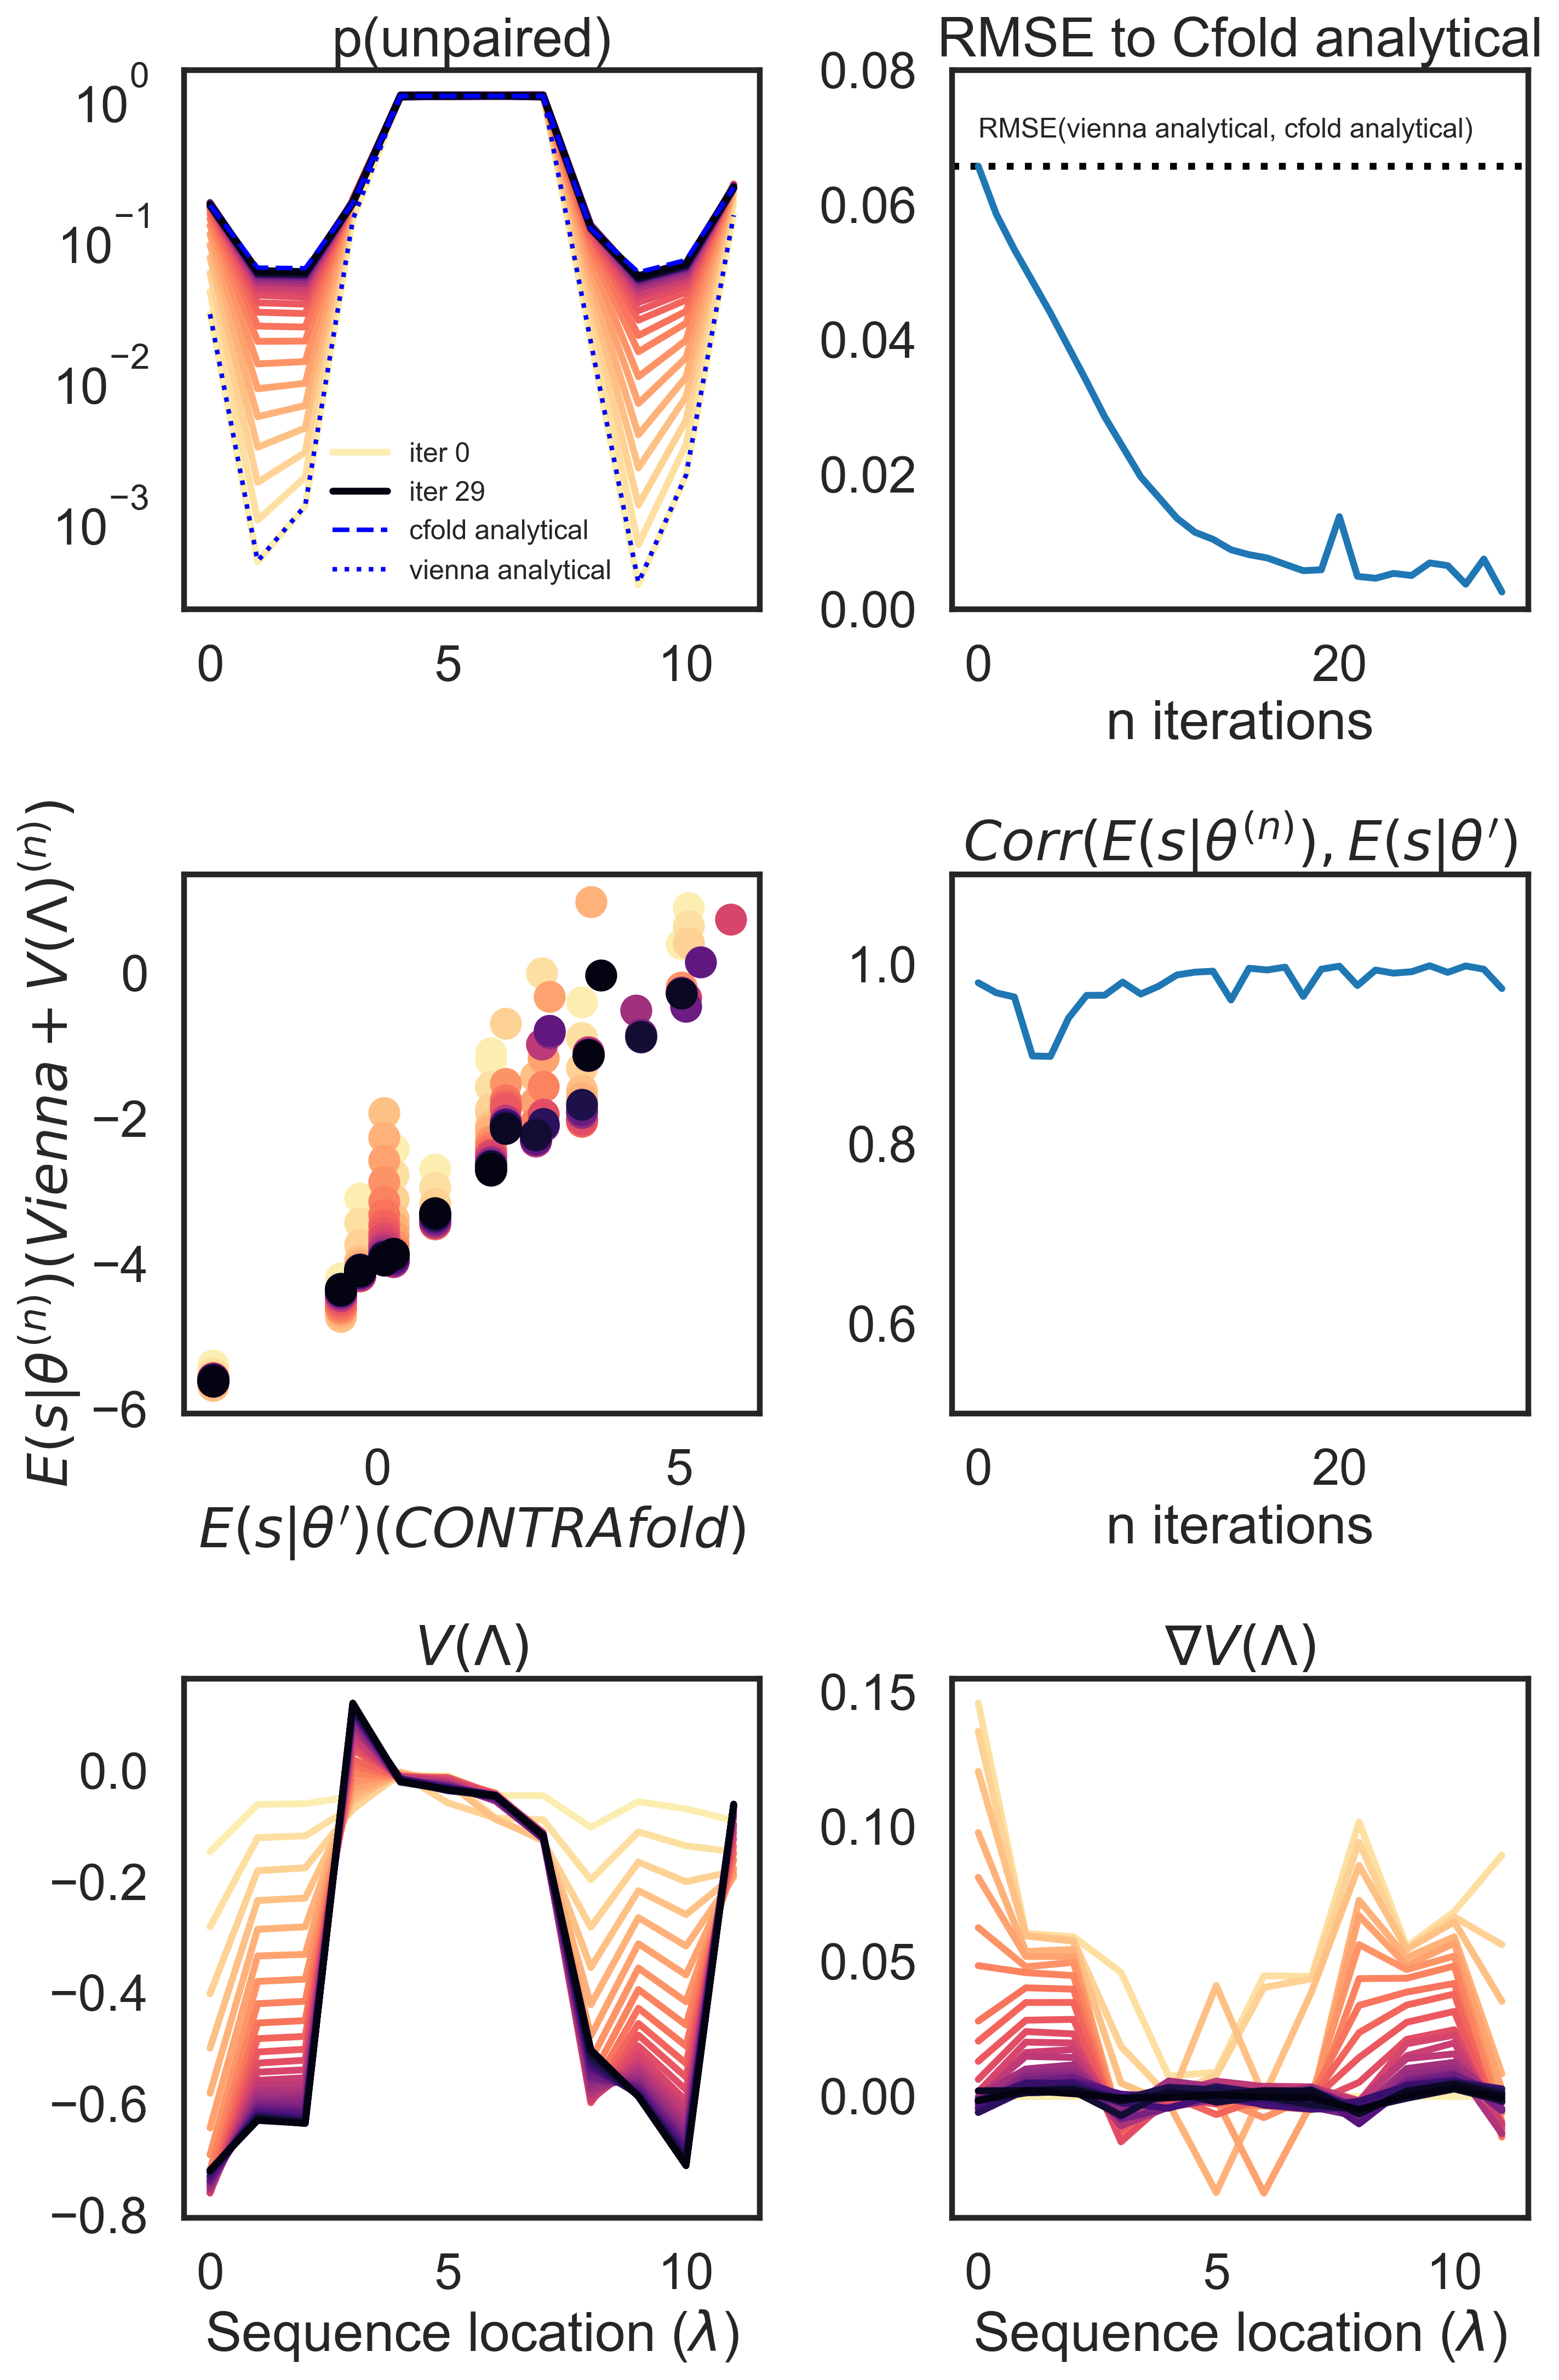

In [295]:
figure(figsize=(10,15))

colors=sns.color_palette('magma_r',estimator.n_iters)
subplot(3,2,1)
title('p(unpaired)')
for i,vec in enumerate(estimator.posteriors):
    if i==0 or i==estimator.n_iters-1:
        plot(vec,c=colors[i],label="iter %d" % i)
    else:
        plot(vec,c=colors[i])

plot(1-np.sum(bpps(sequence,package='contrafold'),axis=0),linewidth=2,label='cfold analytical',color='b',linestyle='--')
plot(1-np.sum(bpps(sequence,package='vienna_2'),axis=0),linewidth=2,label = 'vienna analytical',color='b',linestyle=':')
semilogy()
legend(frameon=False,fontsize=12)

subplot(3,2,2)
cfold_anl = 1 - np.sum(bpps("GGGGAAAACCCC",package='contrafold'),axis=0)
vfold_anl = 1 - np.sum(bpps("GGGGAAAACCCC",package='vienna_2'),axis=0)

axhline(np.sqrt(np.mean(np.square(cfold_anl - vfold_anl))),c='k',linestyle=':')
plot([np.sqrt(np.mean(np.square(x - cfold_anl))) for x in estimator.posteriors])

xlabel('n iterations')
title('RMSE to Cfold analytical')

ylim([0,0.08])
text(0,0.07,"RMSE(vienna analytical, cfold analytical)", fontsize=12)

subplot(3,2,3)

for i in range(estimator.n_iters):
    scatter(estimator.dG_c_uncon[i], estimator.dG_v_uncon[i],color=colors[i])
xlabel(r"$E(s|\theta') (CONTRAfold)$")
ylabel(r"$E(s|\theta^{(n)}) (Vienna + V(\Lambda)^{(n)})$")

subplot(3,2,4)
xlabel('n iterations')
title(r"$Corr(E(s|\theta^{(n)}), E(s|\theta')$")
plot(estimator.dG_corr)
ylim([0.5,1.1])

subplot(3,2,5)
title(r'$V(\Lambda)$')
estimator.plot_perturbation_vectors()
xlabel(r'Sequence location ($\lambda$)')

subplot(3,2,6)
title(r'$\nabla V(\Lambda)$')
estimator.plot_grad_omega()
xlabel(r'Sequence location ($\lambda$)')

tight_layout()
savefig('Fig1.pdf',bbox_inches='tight')

In [206]:
seq = 'ACGCUGUCUGUACUUGUAUCAGUACACUGACGAGUCCCUAAAGGACGAAACAGCGC'

n_samples = 10

#sample unconstrained structures
sampled_structs_uncon = sample_structures(seq, n_samples=n_samples, package='vienna_2', nonredundant=True)

#get free energies for unconstrained structures
dG_v_uncon = np.array([free_energy(seq, constraint = s, package='vienna_2') for s in sampled_structs_uncon])
dG_c_uncon = np.array([free_energy(seq, constraint = s, package='contrafold') for s in sampled_structs_uncon])

#estimate unconstrained partition functions

Z_v_uncon = np.sum(np.exp(-1/kT*dG_v_uncon))
Z_c_uncon = np.sum(np.exp(-1*dG_c_uncon))

Z_v_con, Z_c_con, = [], []

seq_inds = [x for x in range(len(seq))]

#now constrain at location of observable
for i in seq_inds: #striding to reduce compute time for example

    # write constraint string to unpair nucleotide i
    constraint = ['.']*len(seq)
    constraint[i] = 'x'
    constraint = ''.join(constraint)

    # sample structs with nucleotide i unpaired
    sampled_structs = sample_structures(seq, n_samples=n_samples, package='vienna_2',
                                        constraint=constraint, nonredundant=True)

    # compute energies of sampled structures
    dG_v = np.array([free_energy(seq, constraint = s, package='vienna_2') for s in sampled_structs])
    dG_c = np.array([free_energy(seq, constraint = s, package='contrafold') for s in sampled_structs])

    Z_v_con.append(np.sum(np.exp(-1/kT*dG_v)))
    Z_c_con.append(np.sum(np.exp(-1*dG_c)))

v_error = np.sqrt(np.mean(np.square((1-np.sum(bpps(seq,package='vienna_2'))-Z_v_con/Z_v_uncon))))
cfold_error = np.sqrt(np.mean(np.square((1-np.sum(bpps(seq,package='contrafold'))-Z_c_con/Z_c_uncon))))

print(v_error, cfold_error)

31.33900874149291 26.918570272837


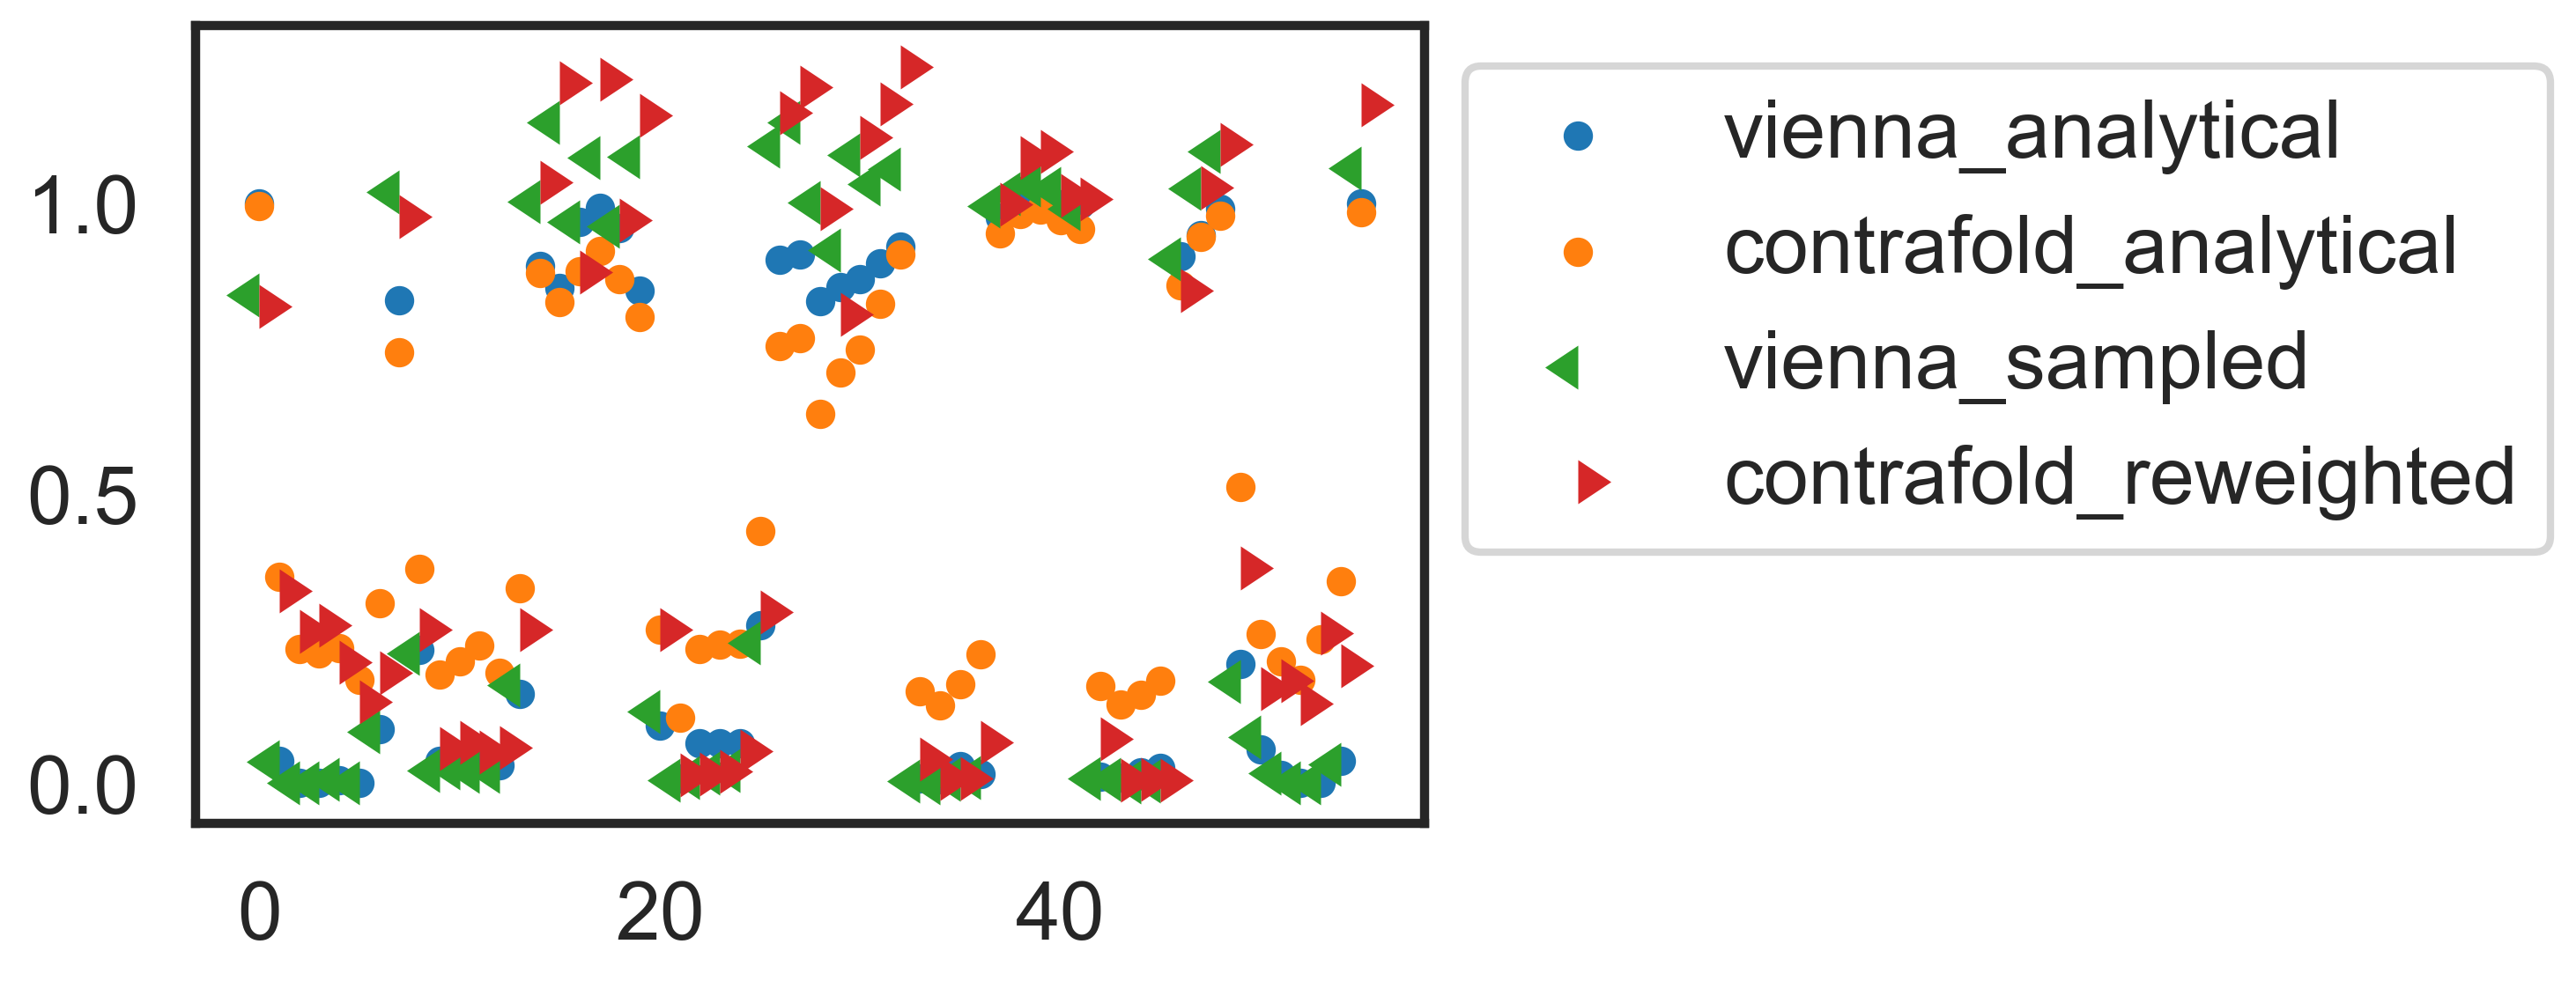

In [207]:
scatter(seq_inds, 1-np.sum(bpps(seq,package='vienna_2'),axis=0),
        label='vienna_analytical',marker='.')
scatter(seq_inds,1-np.sum(bpps(seq,package='contrafold'),axis=0),
        label='contrafold_analytical',marker='.')
scatter(seq_inds,Z_v_con/Z_v_uncon,label='vienna_sampled',marker=8,linewidth=0)
scatter(seq_inds, Z_c_con/Z_c_uncon,label='contrafold_reweighted',marker=9,linewidth=0)
legend(bbox_to_anchor=(1,1))

In [202]:
len(Z_v_con)

6

Text(0.5, 0, 'Vienna dG')

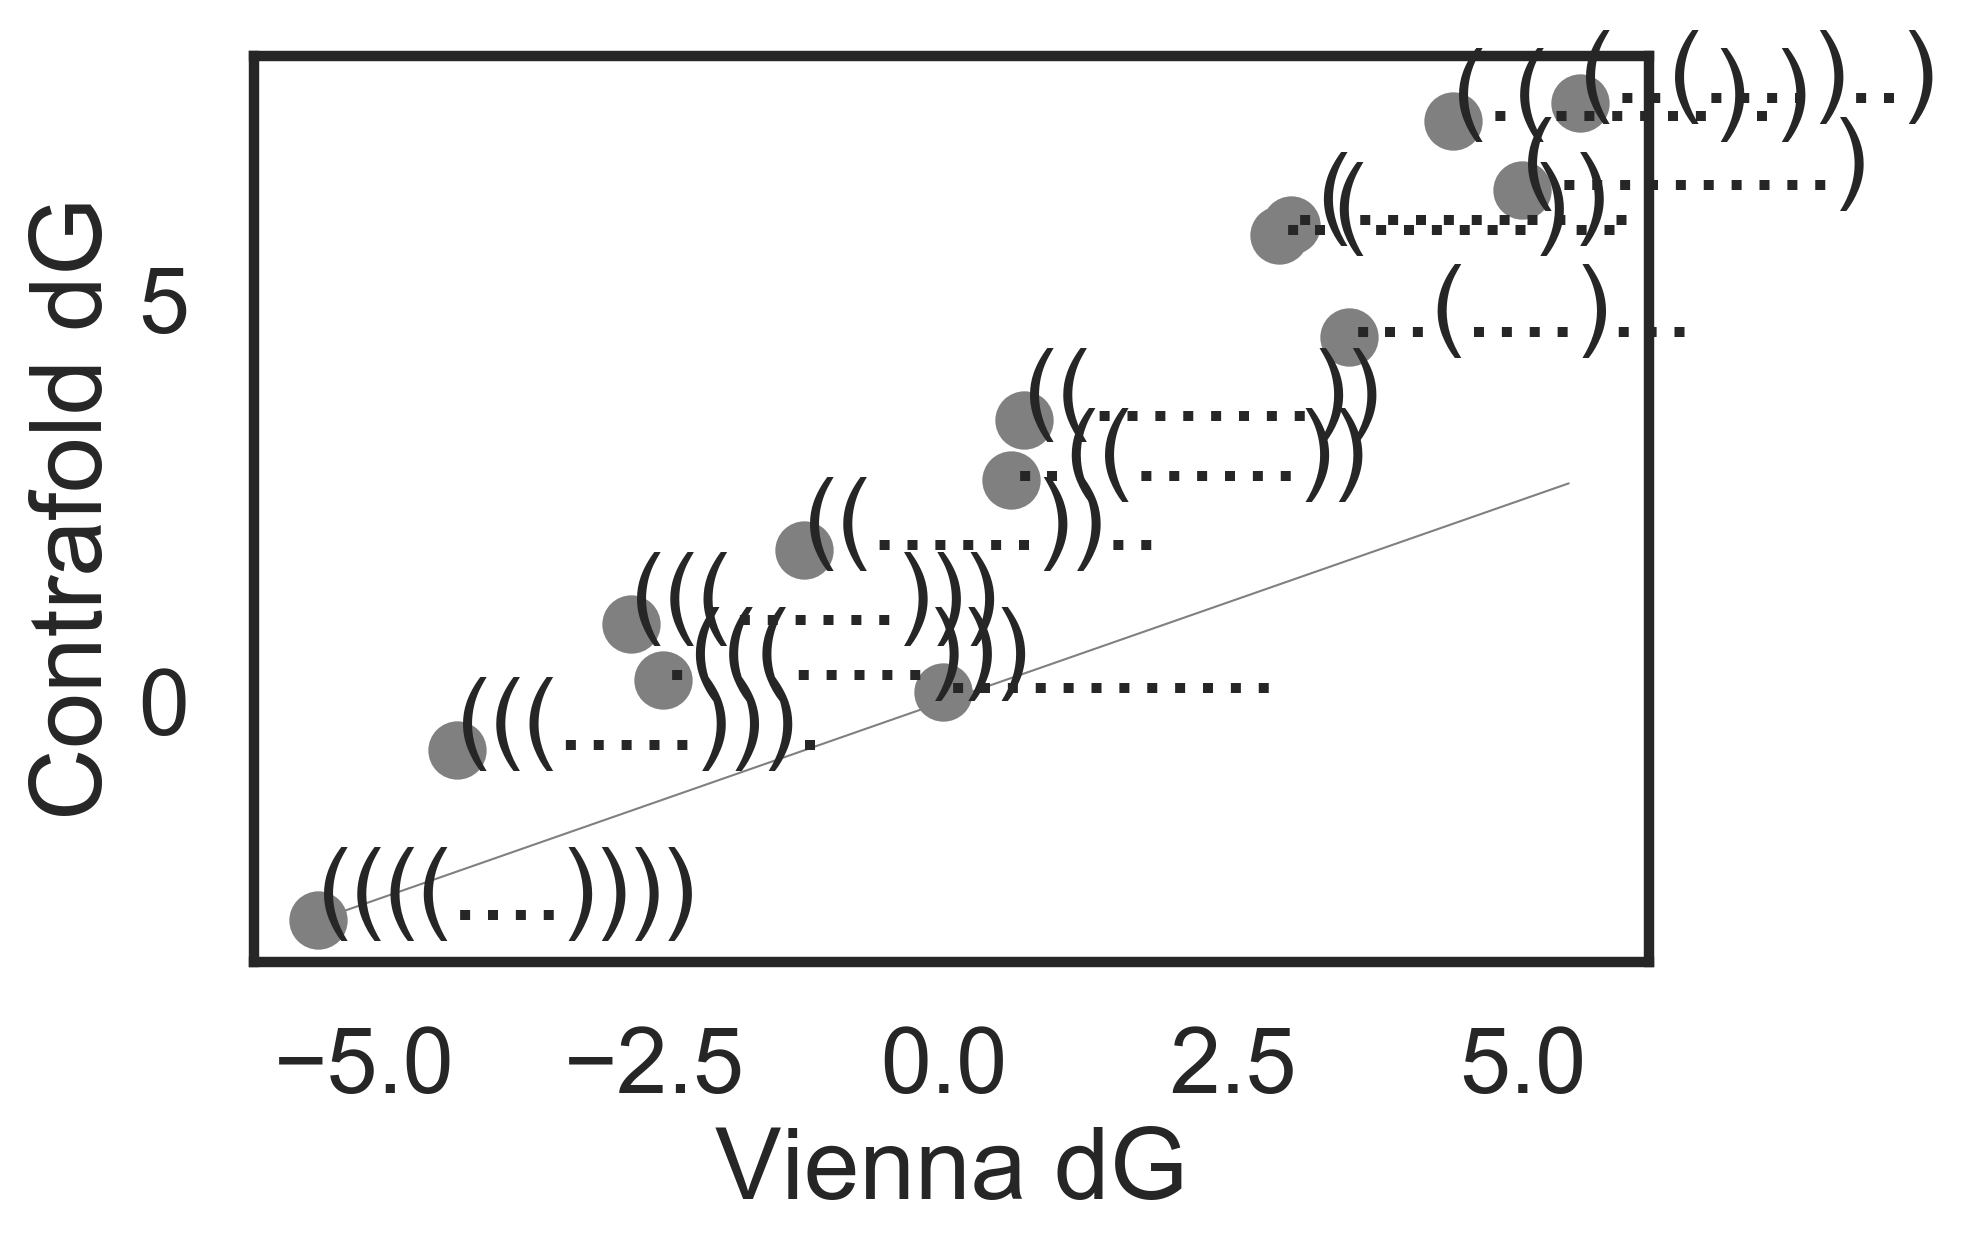

In [129]:
mfe_struct = '((((xxxx))))'
struct_list = ['((((xxxx))))','(((xxxxxx)))','(x(xxxxxx)x)','(xx(xxxx)xx)','x(((xxxxx)))','(((xxxxx)))x',
               'xxxxxxxxxxxx','((xxxxxxxx))','xx((xxxxxx))','((xxxxxx))xx',
               '(xxxxxxxxxx)','x(xxxxxxxx)x','xx(xxxxxx)xx','xxx(xxxx)xxx']
x_mfe,y_mfe = free_energy(sequence,constraint=mfe_struct,package='vienna'), free_energy(sequence,constraint=mfe_struct,package='contrafold')

for struct in struct_list:
    x,y = free_energy(sequence,constraint=struct,package='vienna'),free_energy(sequence,constraint=struct,package='contrafold')
    scatter(x,y,c='grey')
    text(x,y,struct.replace('x','.'))
plot([x_mfe,0,-x_mfe],[y_mfe,0,-y_mfe],color='grey',linewidth=0.5)
ylabel("Contrafold dG")
xlabel("Vienna dG")